In [1]:
!pip install EMD-signal
!pip install vnstock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import PyEMD as pe
from vnstock import *

Observations:  1639
             Open   High    Low  Close   Volume Ticker
Time                                                  
2017-06-02  10590  11040  10510  10950  5519180    SSI
2017-06-05  11000  11040  10740  10740  2811740    SSI
2017-06-06  10800  10910  10720  10870  2952940    SSI
2017-06-07  10950  11140  10930  10980  4110110    SSI
2017-06-08  11040  11210  10930  11060  3599060    SSI
2017-06-09  11120  11300  11080  11140  3427850    SSI


<Axes: xlabel='Time'>

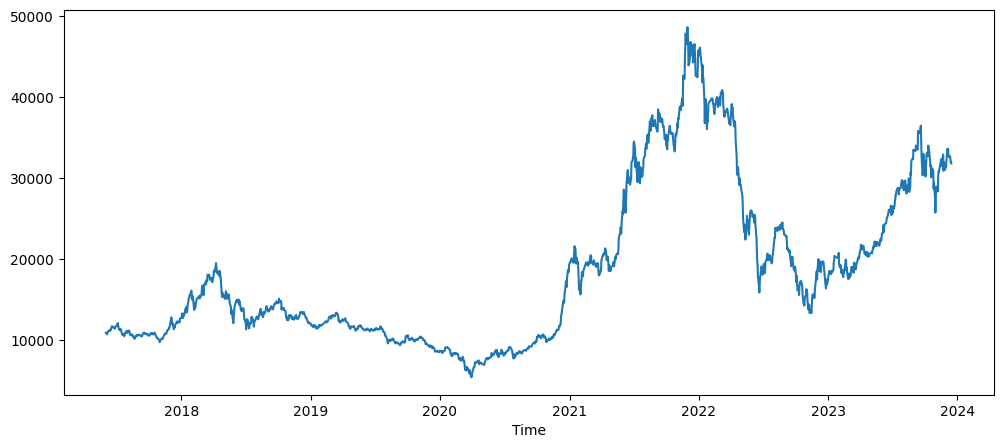

In [3]:
# Import data
SSI = stock_historical_data(symbol = "SSI", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(SSI['Close']))
print(pd.DataFrame(SSI.head(6)))
train_dates = SSI.index
plt.figure(figsize=(12, 5))
SSI["Close"].plot()

In [4]:
SSI = SSI.reset_index(drop = True)
df = SSI['Close']
df

0       10950
1       10740
2       10870
3       10980
4       11060
        ...  
1634    32700
1635    32600
1636    32000
1637    32000
1638    31800
Name: Close, Length: 1639, dtype: int64

In [5]:
## (A) CEEMDAN
#### 1. Thêm white noise vào chuỗi gốc s(t) thành chuỗi s1(t)
#### 2. Decompose chuỗi s1(t) bằng EMD ra các chuỗi IMF1 và Residue1
#### 3. Trung bình các chuỗi IMF1(t) thành mIMF1(t)
#### 4. r1(t) = s1(t) - mIMF1(t)
#### 5. Chuỗi mới s2(t) = r1(t) + coef*EMD(noise)
#### 6. Làm lại từ 1->5 đến khi chuỗi residue dừng

In [6]:
from PyEMD import EMD, CEEMDAN

In [7]:
ceemdan = CEEMDAN(range_thr=0.001, total_power_thr=0.01)
cIMFs = ceemdan.ceemdan(S=np.array(df.values), T= np.array(df.index))

In [8]:
pd.DataFrame(cIMFs.T, columns = ["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7
0,64.391229,-31.907481,-582.328457,254.739202,1584.678892,-2173.411288,11833.837903
1,-90.975422,-73.535398,-596.253561,252.212097,1587.512340,-2173.228961,11834.268905
2,12.379649,-58.323754,-585.173841,249.523018,1589.264910,-2172.363071,11834.693090
3,20.579219,9.608194,-551.072037,246.664332,1589.917905,-2170.807998,11835.110385
4,0.918484,57.418123,-498.374986,243.618315,1589.457741,-2168.558560,11835.520882
...,...,...,...,...,...,...,...
1634,72.264340,-398.609037,57.068900,2442.916981,14088.344245,-15006.927172,31444.941743
1635,152.341287,-422.252458,-116.200095,2469.390053,14051.404596,-14977.663745,31442.980362
1636,-144.783504,-578.293545,-248.912702,2461.694164,14017.383751,-14948.062479,31440.974316
1637,121.956675,-737.004027,-307.874247,2415.905780,13986.218636,-14918.126469,31438.923651


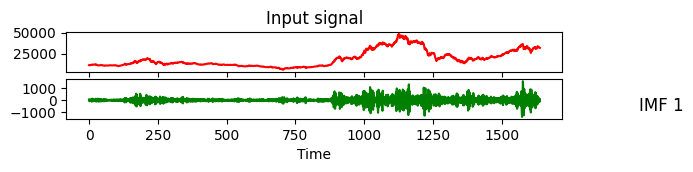

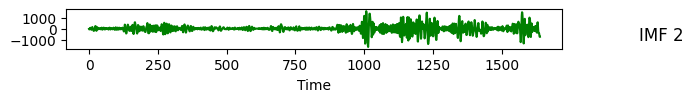

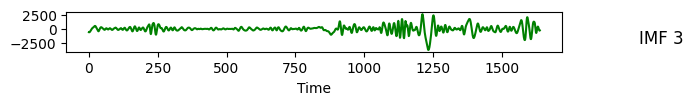

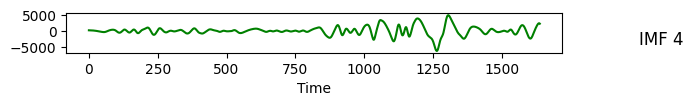

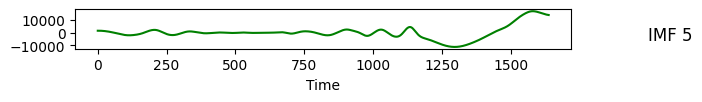

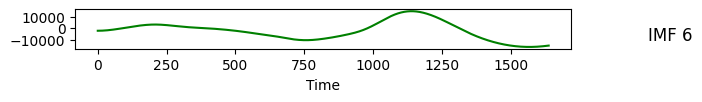

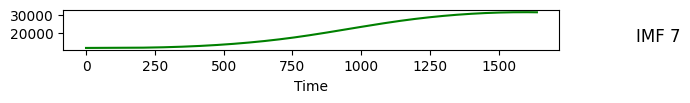

In [9]:
N = cIMFs.shape[0]+1
# Plot results
plt.subplot(N,1,1)
plt.plot(df.index, df.values, 'r')
plt.title("Input signal")
plt.xlabel("Time")

for n, imf in enumerate(cIMFs):
  plt.subplot(N,1,n+2)
  plt.plot(df.index, imf, 'g')
  plt.title("IMF "+str(n+1), x=1.2, y = 0)
  plt.xlabel("Time")
  plt.show()

In [10]:
# Tính residue
scIMF = cIMFs.sum(axis = 0).reshape(-1, 1)
residue = (np.array(df)-cIMFs.sum(axis = 0)).reshape(-1,1)

print("sIMF:", scIMF.shape)
print("Residue:", residue.shape)

sIMF: (1639, 1)
Residue: (1639, 1)


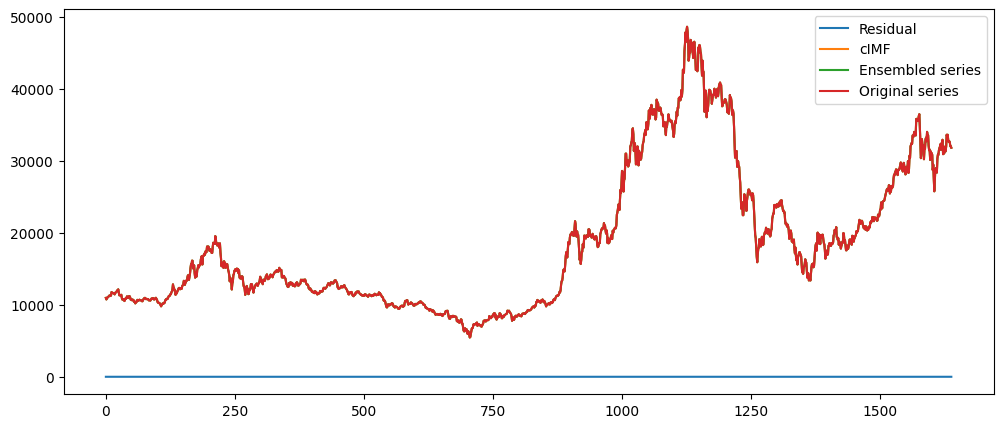

In [11]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(df)), residue)
plt.plot(range(0,len(df)), scIMF)
plt.plot(range(0,len(df)), scIMF+residue)
plt.plot(df)
plt.legend(["Residual", "cIMF", "Ensembled series", "Original series"])

plt.show()

In [12]:
# (B) LSTM
## 0. Prepocessing
# load các thư viện cần thiết
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

In [31]:
cIMF = cIMFs.sum(axis = 0).reshape(-1, 1)+residue
cIMF.shape

(1639, 1)

In [14]:
# Scale data to 0-1
scaler = StandardScaler()
def Scaling (data):
    IMFscale = scaler.fit_transform(np.array(data))

    return IMFscale
IMFscale = Scaling(cIMF)
#train_scaled = scaler.inverse_transform(train_scaled)
#pd.DataFrame(train_scaled, columns=["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

(1639, 1)
Train:  (1147, 1)
Test:  (492, 1)


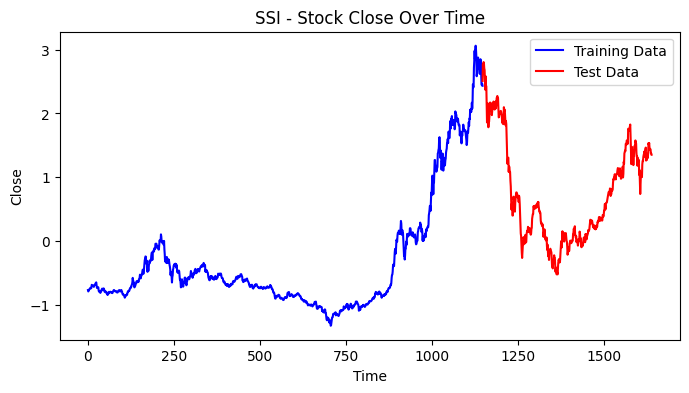

In [16]:
print(IMFscale.shape)
# Chia train test
train_size = int(0.7*IMFscale.shape[0])
test_size = int(0.3*IMFscale.shape[0])
train_data = IMFscale[:train_size].reshape(-1,1)
test_data = IMFscale[train_size:].reshape(-1,1)

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)

# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size -1,  train_size+test_size), test_data, linestyle='-',  color='r', label='Test Data')


plt.title('SSI - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [17]:
trainX = []
trainY = []

n_past = 60
n_future = 1

for i in range(n_past, len(train_data) - n_future + 1):
    past_sequence = train_data[i - n_past:i, 0:train_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = train_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)
print("X train: ", trainX.shape)
print("Y train: ", trainY.shape)

X train:  (1087, 60, 1)
Y train:  (1087, 1)


In [18]:
testX = []
testY = []

for i in range(n_past, len(test_data) - n_future + 1):
    past_sequence = test_data[i - n_past:i, 0:test_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = test_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)

print("X test: ", testX.shape)
print("Y test: ", testY.shape)

X test:  (432, 60, 1)
Y test:  (432, 1)


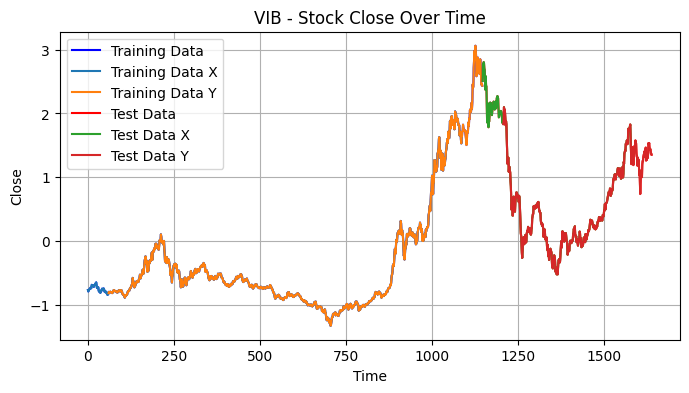

In [19]:
# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size-n_past), trainX[:,0,0], linestyle='-', label='Training Data X')
plt.plot(range(n_past,train_size), trainY[:,0], linestyle='-', label='Training Data Y')
plt.plot(range(train_size, train_size+test_size+1), test_data, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size, train_size+test_size-n_past+1), testX[:,0,0], linestyle='-',  label='Test Data X')
plt.plot(range(train_size+n_past, train_size+test_size+1), testY[:,0], linestyle='-', label='Test Data Y')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
## 1. Train model
# Tạo model lstm cho việc training
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mape')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=4, validation_split=0.1, verbose=1)

Epoch 1/100
245/245 [==============================] - 25s 70ms/step - loss: 58.4991 - val_loss: 586.7780
Epoch 2/100
245/245 [==============================] - 11s 43ms/step - loss: 38.2016 - val_loss: 10434.1445
Epoch 3/100
245/245 [==============================] - 14s 58ms/step - loss: 37.2080 - val_loss: 59.2522
Epoch 4/100
245/245 [==============================] - 8s 34ms/step - loss: 32.3835 - val_loss: 21710.6348
Epoch 5/100
245/245 [==============================] - 10s 40ms/step - loss: 30.9932 - val_loss: 21.3916
Epoch 6/100
245/245 [==============================] - 10s 40ms/step - loss: 30.8766 - val_loss: 30.6261
Epoch 7/100
245/245 [==============================] - 8s 34ms/step - loss: 30.7795 - val_loss: 35.9079
Epoch 8/100
245/245 [==============================] - 10s 40ms/step - loss: 29.0712 - val_loss: 31.8259
Epoch 9/100
245/245 [==============================] - 10s 40ms/step - loss: 32.3027 - val_loss: 29.3670
Epoch 10/100
245/245 [============================

In [33]:
prediction = model.predict(testX)
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)

y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

14/14 [==============================] - 1s 33ms/step
(432, 1)
(432, 1)
[32560.758  32848.543  33254.168  34288.094  32904.633  34136.98
 33001.703  33143.273  32388.916  33405.65   32325.137  31755.725
 30669.709  29757.018  30280.646  30516.682  30261.414  28737.271
 29995.402  29305.205  28951.02   29093.148  28001.06   27662.617
 26272.467  25072.14   25353.688  25001.445  23658.578  23212.654
 23948.172  25842.15   25262.914  25171.828  25162.047  23932.02
 24757.027  25322.38   25835.273  26192.56   26221.977  26129.432
 26132.807  25800.104  25981.08   25786.799  25263.553  25977.32
 25705.555  24982.883  23744.72   22562.508  21286.957  20233.19
 19441.502  18973.9    18720.387  18626.014  18588.777  18569.002
 18559.062  18550.916  18545.582  18541.05   18538.293  18572.055
 18582.764  18564.688  18553.098  18630.4    19021.674  19589.715
 19893.346  20502.506  20491.861  20221.322  19796.873  19636.957
 19492.016  19217.205  18925.01   18753.607  18665.395  18854.613
 19387.4

In [23]:
train_back = scaler.inverse_transform(train_data)
test_back = scaler.inverse_transform(test_data)

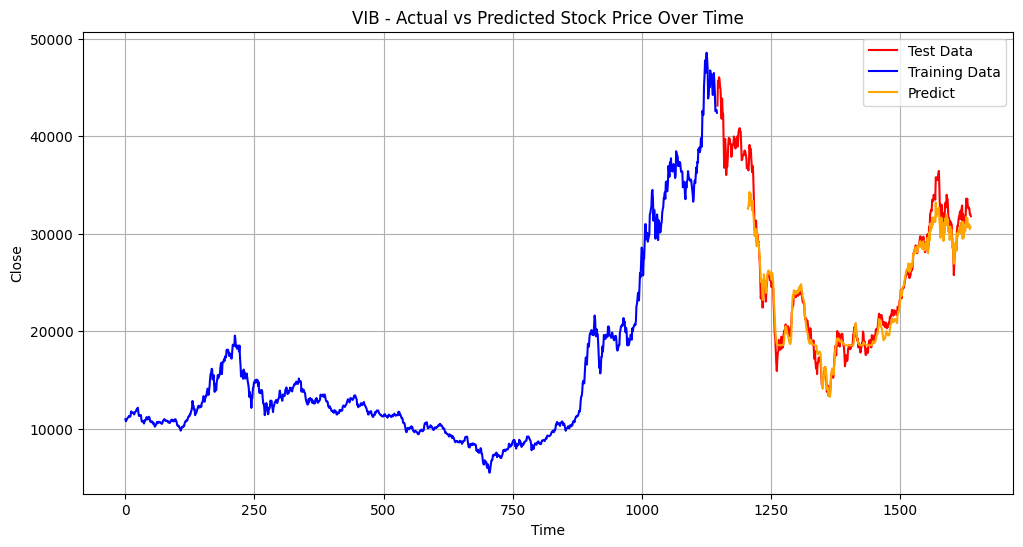

In [24]:
plt.figure(figsize=(12, 6))
n_future = 60

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+n_future-1, train_size+test_size),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
#plt.plot( test_Date, y_pred, label='Predicted', linestyle='-',  color='b')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
n_past = 1
n_days_for_prediction= 60

#print(test_data.reshape(1,-1).T.shape)

test_for_forecast = test_data.reshape(1,-1).T

x_forecast = []
y_forecast = []

for i in range(n_days_for_prediction):
  # B1 Duyệt dữ liệu test n ngày gần nhất => bỏ vào x tạm
  x = np.array(test_for_forecast[(-60):])
  print(x.shape)
  x = x.T.reshape(x.shape[1], x.shape[0], 1)
  print(x.shape)

  # B2 dùng predict để chạy 1 ngày
  y = model.predict(x)
  # B3 thêm data ngày đó vào y_forecast, test_for_forecast và append x vào x_forecast
  y_c = np.repeat(y, x.shape[1], axis=-1)
  y_pr = scaler.inverse_transform(y_c)[:,0]

  x_forecast.append(x)
  y_forecast.append(y_pr)
  test_for_forecast = np.append(test_for_forecast, y).reshape(-1,1)
  print(test_for_forecast.shape)
  #test_for_forecast.append(y)
  # B4 lặp lại đến ngày thứ 60

x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 24ms/step
(493, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 27ms/step
(494, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 30ms/step
(495, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 24ms/step
(496, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 24ms/step
(497, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 24ms/step
(498, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 24ms/step
(499, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 23ms/step
(500, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(501, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 24ms/step
(502, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 24ms/step
(503, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(504, 1)
(60, 1)
(1, 60, 1)
1/1 [================

In [26]:
print(y_forecast)

[[30432.752]
 [29567.367]
 [29338.432]
 [29212.812]
 [29098.17 ]
 [28992.883]
 [28903.604]
 [28829.398]
 [28767.291]
 [28715.303]
 [28672.092]
 [28636.393]
 [28606.96 ]
 [28582.693]
 [28562.652]
 [28546.082]
 [28532.363]
 [28520.99 ]
 [28511.557]
 [28503.729]
 [28497.232]
 [28491.84 ]
 [28487.365]
 [28483.65 ]
 [28480.568]
 [28478.012]
 [28475.89 ]
 [28474.129]
 [28472.668]
 [28471.457]
 [28470.451]
 [28469.615]
 [28468.924]
 [28468.346]
 [28467.87 ]
 [28467.473]
 [28467.143]
 [28466.871]
 [28466.646]
 [28466.459]
 [28466.3  ]
 [28466.172]
 [28466.064]
 [28465.975]
 [28465.902]
 [28465.84 ]
 [28465.79 ]
 [28465.746]
 [28465.71 ]
 [28465.682]
 [28465.658]
 [28465.639]
 [28465.623]
 [28465.61 ]
 [28465.598]
 [28465.588]
 [28465.58 ]
 [28465.574]
 [28465.566]
 [28465.562]]


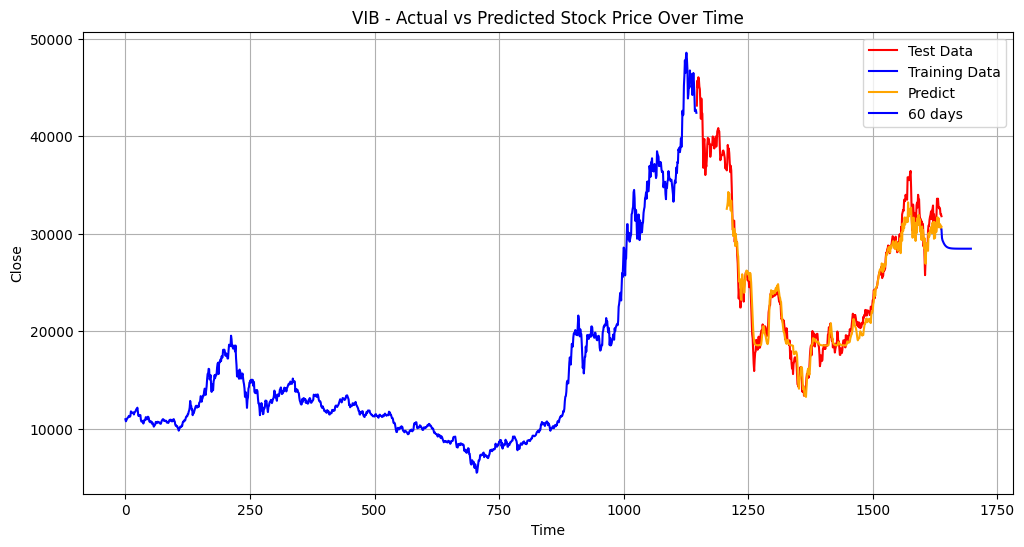

In [27]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
# Plot predict test and actual test
plt.plot(range(train_size + 60, train_size + test_size+1),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# Plot 60 days
plt.plot(range(train_size+test_size, train_size+test_size+60), y_forecast, linestyle='-', color='b', label='60 days')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [28]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100

In [29]:
print("RSME: ", RSME(y_pred_future, test_back[60:]))
print("MAE: ", MAE(y_pred_future, test_back[60:]))
print("MAPE: ", MAPE(y_pred_future, test_back[60:]))

RSME:  9671.790258295767
MAE:  8197.867857228974
MAPE:  25.990151168554476


In [30]:
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("MSLR: ", MSLE(y_pred_future, test_back[60:]))

MSLR:  0.13472071785171993
